In [1]:
using PyPlot
include("acoustic_solver.jl")
include("inverse_func.jl")
include("W2_func.jl")

compute_adj_source_core (generic function with 1 method)

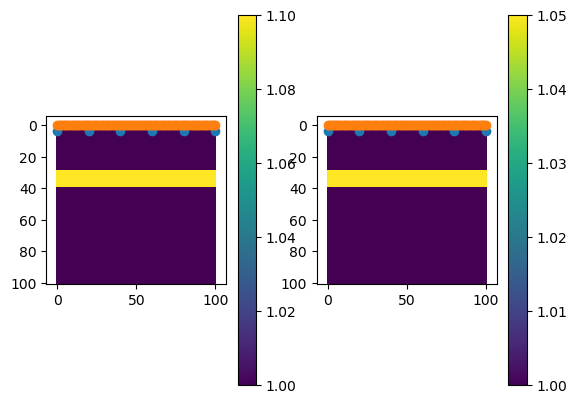

PyObject <matplotlib.collections.PathCollection object at 0x13bbb61d0>

In [2]:
Nx = 101;
Ny = 101;
h = 0.01;

Nt = 1001;
Fs = 500;
dt = 1/Fs;
t = range(0, length=Nt, step=dt);

# source
# f = sin.(2*pi*5*t);
f = source_ricker(5,0.2,t)
source_num = 6
source = zeros(Nt, source_num);
for i = 1:source_num
    source[:,i] = f;
end
source_position = zeros(Int, source_num, 2);
for i = 1:source_num
    source_position[i,1] = 5;
    source_position[i,2] = 20*(i-1)+1;
end

# receiver
receiver_num = 101;
receiver_position = zeros(Int, receiver_num, 2);
for i = 1:receiver_num
    receiver_position[i,1] = 1
    receiver_position[i,2] = i
end

# model
c = 1*ones(Nx,Ny);
rho = 1*ones(Nx,Ny);
c[30:40,:] .= 1.1;

using ImageFiltering
c0 =1*ones(Nx,Ny);
c0[30:40,:] .= 1.05;

subplot(121)
imshow(c); colorbar()
scatter(source_position[:,2].-1, source_position[:,1].-1)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1)

subplot(122)
imshow(c0); colorbar()
scatter(source_position[:,2].-1, source_position[:,1].-1)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1)

In [3]:
a = 1 ./ (c.^2 .* rho);
a0 = 1 ./ (c0.^2 .* rho);

### Simulate

In [4]:
@time received_data, wavefield = multi_solver(c, rho, Nx, Ny, Nt, h, dt, source, source_position, receiver_position);

 45.107660 seconds (10.15 M allocations: 63.260 GiB, 19.50% gc time)


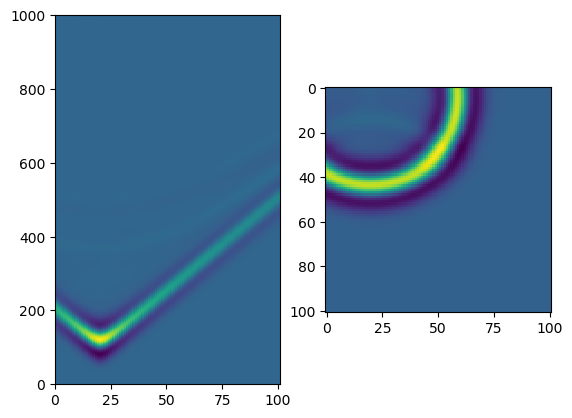

PyObject <matplotlib.image.AxesImage object at 0x15a4422b0>

In [5]:
subplot(121); pcolor(received_data[:,:,2])
subplot(122); imshow(wavefield[:,:,300,2])

### Forward modelling

In [6]:
@time d, u =  multi_solver(c0, rho, Nx, Ny, Nt, h, dt, source, source_position, receiver_position);

 42.067668 seconds (1.64 M allocations: 62.852 GiB, 20.66% gc time)


### Adjoint method

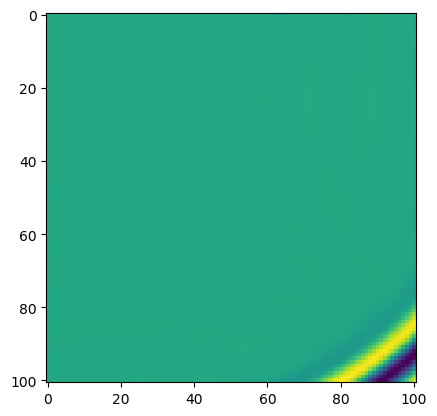

PyObject <matplotlib.image.AxesImage object at 0x15edc24e0>

In [7]:
utt = similar(u);
for i = 2:Nt-1
    utt[:,:,i,:] = (u[:,:,i+1,:]-2*u[:,:,i,:]+u[:,:,i-1,:]) ./ (2*dt);
end
utt[:,:,:,:] = utt[:,:,end:-1:1,:];
imshow(utt[:,:,300,2])

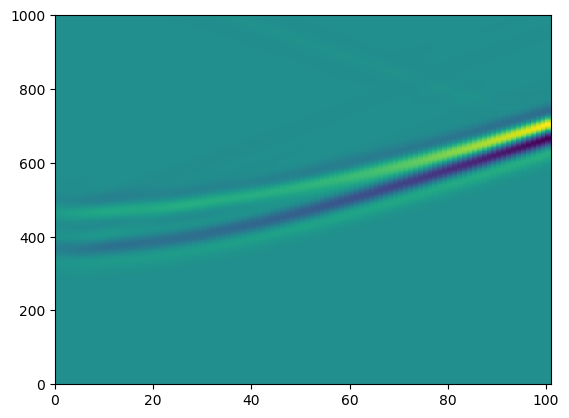

PyObject <matplotlib.collections.PolyCollection object at 0x13be057f0>

In [8]:
# adjoint source
adj_source1 = d - received_data;
pcolor(adj_source1[:,:,1])

Test W2 adjoint

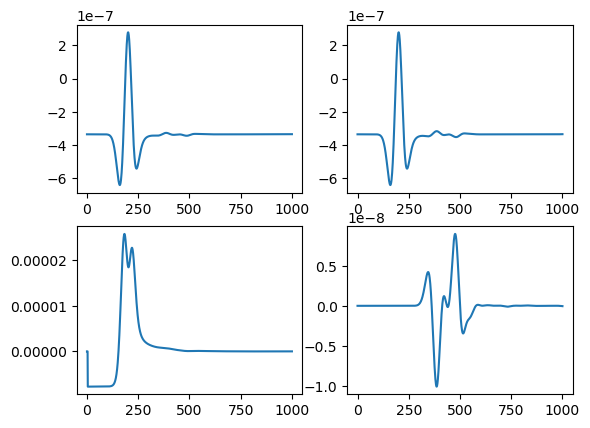

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x159d9fc50>

In [9]:
ind_receiver = 20; ind_source = 1;
f = d[:, ind_receiver, ind_source]
g = received_data[:, ind_receiver, ind_source]
fmin = minimum(f);
gmin = minimum(g);
f = f .+ 1.1*min(fmin,gmin)
g = g .+ 1.1*min(fmin,gmin)
sig = compute_adj_source_core(f, g, t, Nt, dt);

subplot(221); plot(f)
subplot(222); plot(g)
subplot(223); plot(sig)
subplot(224); plot(f-g)

In [10]:
adj_source = zeros(Nt, receiver_num, source_num)
for ind_source = 1:source_num
    for ind_receiver = 1:receiver_num
        f = d[:, ind_receiver, ind_source]
        g = received_data[:, ind_receiver, ind_source]
        fmin = minimum(f);
        gmin = minimum(g);
        f = f .+ 1.5*min(fmin,gmin)
        g = g .+ 1.5*min(fmin,gmin)
        adj_source[:,ind_receiver,ind_source] = compute_adj_source_core(f, g, t, Nt, dt);
    end
end

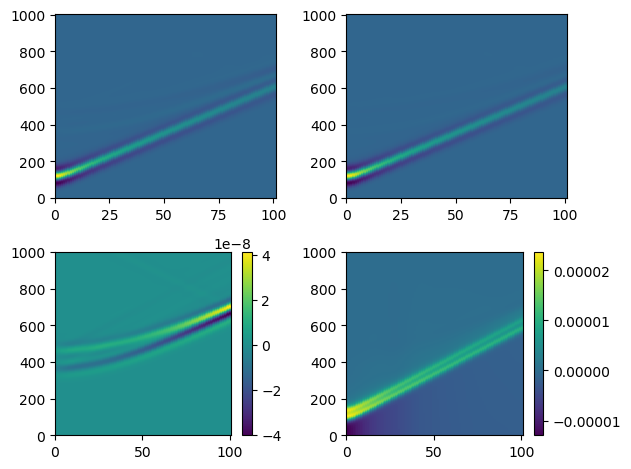

In [11]:
subplot(221); pcolor(received_data[:,:,1])
subplot(222); pcolor(d[:,:,1])
subplot(223); pcolor(adj_source1[:,:,1]); colorbar()
subplot(224); pcolor(adj_source[:,:,1]); colorbar()
tight_layout()

In [12]:
# backward wavefield
v = backward_solver(c0, rho, Nx, Ny, Nt, h, dt, adj_source, source_position, receiver_position);
v1 = backward_solver(c0, rho, Nx, Ny, Nt, h, dt, adj_source1, source_position, receiver_position);

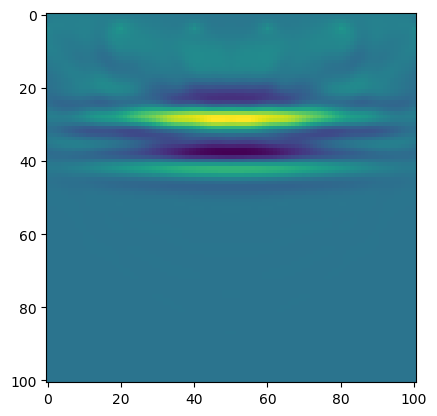

PyObject <matplotlib.image.AxesImage object at 0x183cea198>

In [13]:
# Integration 
grad = zeros(Nx, Ny);
for i = 1:source_num
    g = utt[:,:,:,i] .* v1[:,:,:,i];
    g = sum(g, dims=3)
    grad += g[:,:,1];
end
imshow(grad)

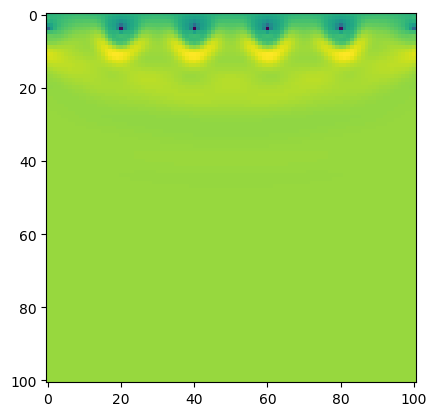

PyObject <matplotlib.image.AxesImage object at 0x15a8b3400>

In [14]:
grad = zeros(Nx, Ny);
for i = 1:source_num
    g = utt[:,:,:,i] .* v[:,:,:,i];
    g = sum(g, dims=3)
    grad += g[:,:,1];
end
grad[findall(x->x==NaN,grad)] .= 0
imshow(grad)